In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/Pneumonia FL/train/'
test_dir = '/content/drive/MyDrive/Pneumonia FL/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

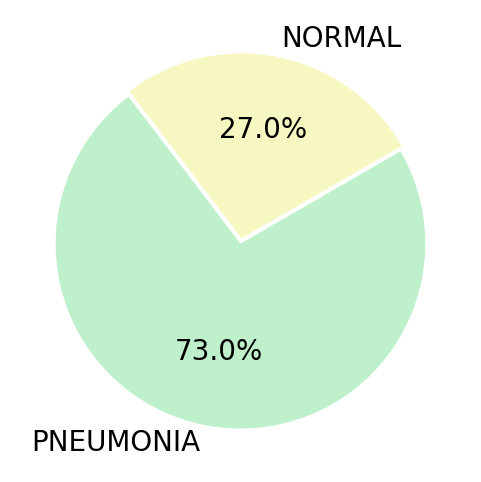

In [4]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB']
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x=='NORMAL']),
         len([x for x in train_labels if x=='PNEUMONIA'])],
        labels=['NORMAL','PNEUMONIA'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015),
        startangle=30);

In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

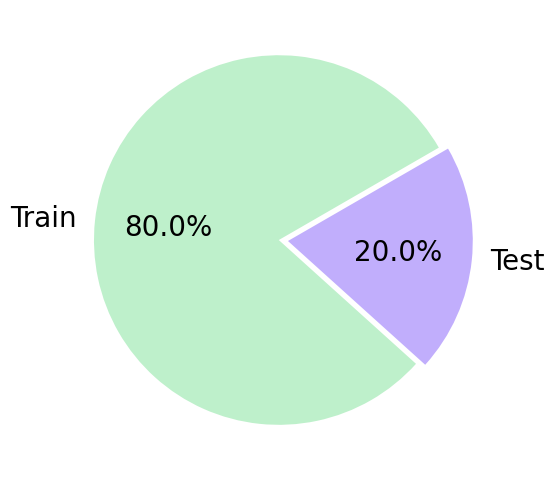

In [6]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [7]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

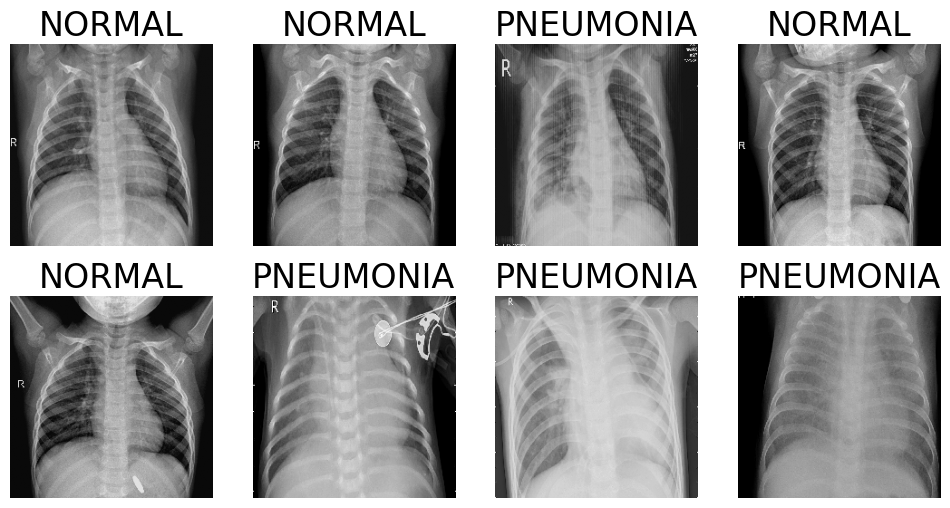

In [8]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [9]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [10]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [11]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

mob   = MobileNet(include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(mob), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['input_1[0][0]']             
 onal)                                                                                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_1[0][0]']             
                                                          8                                       
                                                                                              

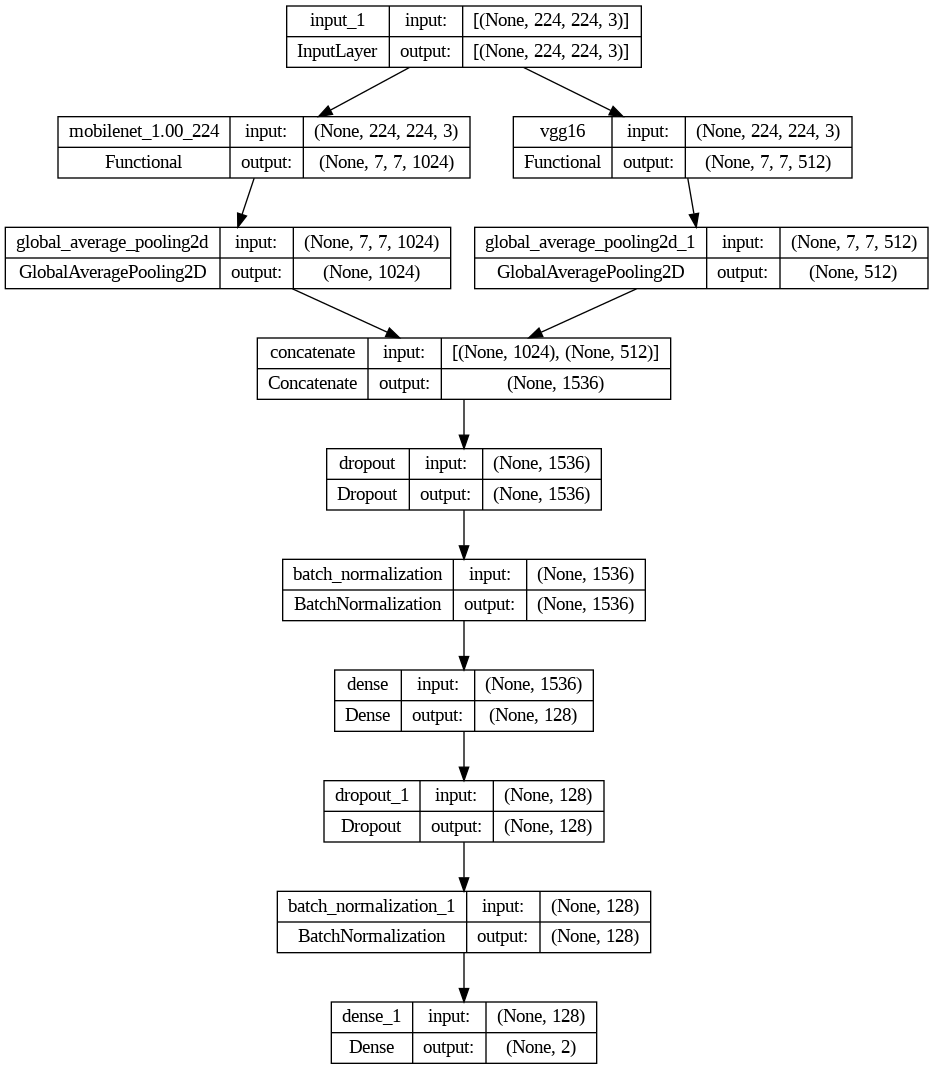

In [13]:
keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [15]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 1674s 7s/step - loss: 0.3757 - sparse_categorical_accuracy: 0.8611
Epoch 2/10
234/234 [==============================] - 93s 371ms/step - loss: 0.1813 - sparse_categorical_accuracy: 0.9410
Epoch 3/10
234/234 [==============================] - 86s 369ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.9605
Epoch 4/10
234/234 [==============================] - 87s 372ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9745
Epoch 5/10
234/234 [==============================] - 87s 371ms/step - loss: 0.0624 - sparse_categorical_accuracy: 0.9820
Epoch 6/10
234/234 [==============================] - 87s 370ms/step - loss: 0.0500 - sparse_categorical_accuracy: 0.9837
Epoch 7/10
234/234 [==============================] - 86s 369ms/step - loss: 0.0475 - sparse_categorical_accuracy: 0.9854
Epoch 8/10
234/234 [==============================] - 86s 369ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9878
Epoch 9/10
234/234 [=====

# Federated Learning Based transfer Learning enabled VGG16+MobileNet Model

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
58/58 [==============================] - 37s 380ms/step - loss: 0.0540 - sparse_categorical_accuracy: 0.9862
Epoch 2/5
58/58 [==============================] - 31s 372ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9852
Epoch 3/5
58/58 [==============================] - 21s 364ms/step - loss: 0.0305 - sparse_categorical_accuracy: 0.9887
Epoch 4/5
58/58 [==============================] - 21s 361ms/step - loss: 0.0161 - sparse_categorical_accuracy: 0.9957
Epoch 5/5
58/58 [==============================] - 21s 364ms/step - loss: 0.0261 - sparse_categorical_accuracy: 0.9922
Epoch 1/5
58/58 [==============================] - 37s 379ms/step - loss: 0.0146 - sparse_categorical_accuracy: 0.9957
Epoch 2/5
58/58 [==============================] - 22s 381ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9930
Epoch 3/5
58/58 [==============================] - 21s 365ms/step - loss: 0.0148 - sparse_categorical_accuracy: 0.9965
Epoch 4/5
58/58 [==============================]

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


  3%|▎         | 1/36 [00:30<17:41, 30.34s/it]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 2/36 [00:43<11:18, 19.94s/it]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 3/36 [01:05<11:37, 21.14s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 4/36 [01:36<13:25, 25.16s/it]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 5/36 [01:49<10:35, 20.49s/it]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 6/36 [02:01<08:54, 17.81s/it]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 7/36 [02:15<08:01, 16.60s/it]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 8/36 [02:28<07:10, 15.37s/it]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 9/36 [02:40<06:25, 14.26s/it]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 10/36 [02:52<05:52, 13.56s/it]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 11/36 [03:11<06:19, 15.18s/it]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 12/36 [03:24<05:48, 14.50s/it]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 13/36 [03:41<05:53, 15.36s/it]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 14/36 [03:55<05:28, 14.92s/it]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 15/36 [04:07<04:54, 14.02s/it]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 16/36 [04:18<04:23, 13.17s/it]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 17/36 [04:33<04:22, 13.84s/it]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 18/36 [04:54<04:43, 15.72s/it]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 19/36 [05:07<04:17, 15.17s/it]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 20/36 [05:19<03:47, 14.24s/it]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 21/36 [05:31<03:22, 13.52s/it]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 22/36 [05:45<03:08, 13.50s/it]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 23/36 [06:00<03:02, 14.00s/it]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 24/36 [06:18<03:02, 15.24s/it]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 25/36 [06:30<02:38, 14.39s/it]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 26/36 [06:43<02:19, 13.91s/it]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 27/36 [06:56<02:02, 13.61s/it]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 28/36 [07:10<01:49, 13.68s/it]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 29/36 [07:24<01:36, 13.73s/it]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 30/36 [07:36<01:19, 13.27s/it]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 31/36 [07:48<01:05, 13.00s/it]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 32/36 [08:00<00:50, 12.69s/it]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 33/36 [08:12<00:37, 12.47s/it]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 34/36 [08:29<00:27, 13.77s/it]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 35/36 [08:43<00:13, 13.71s/it]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 36/36 [08:56<00:00, 13.48s/it]

1/1 [==============================] - 1s 825ms/step


37it [09:15, 15.02s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.94      0.96      0.95       317
   PNEUMONIA       0.99      0.98      0.98       855

    accuracy                           0.97      1172
   macro avg       0.97      0.97      0.97      1172
weighted avg       0.97      0.97      0.97      1172



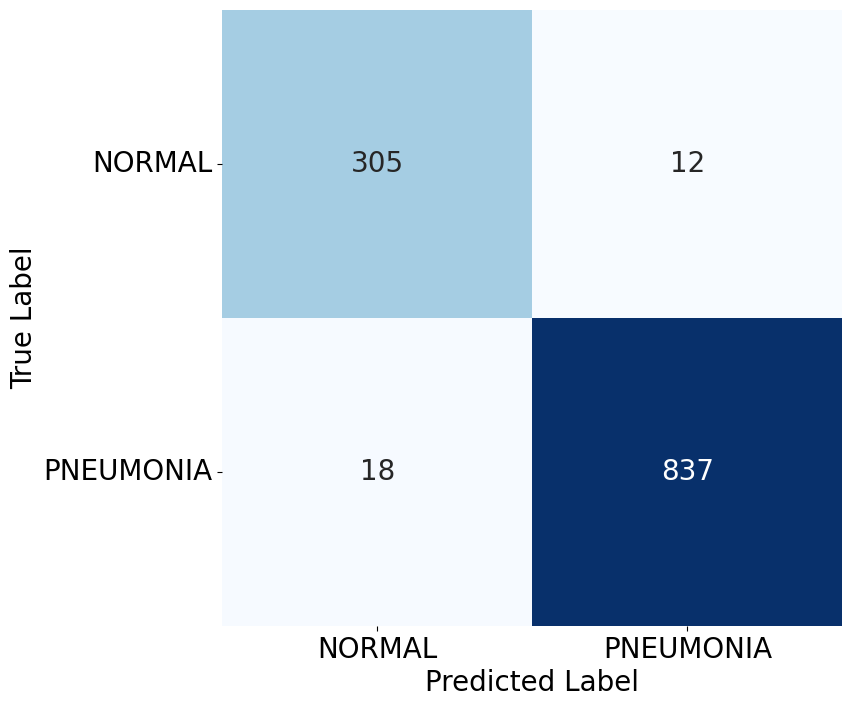

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



In [19]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 837.000000 TN: 305.000000 FP: 12.000000 FN: 18.000000


In [22]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
specificity=TN/float(TN+FP)
print('Specificity: %.4f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.4f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.4f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.4f' % f1)

Specificity: 0.9621
 Recall: 0.9789
 Precision: 0.9859
F1 Score: 0.9824
